In [1]:
##IMPORTS
#Basics
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os # create directories in the local filesystem
from tqdm import tqdm # plot progress bars
import plotly.express as px

#PyTorch
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import  DataLoader
from torch import nn


import torch.optim as optim
import torch.nn.functional as F

#Pytoprch lightning


#For Optuna (Hyperparameters search)
import optuna
from optuna.integration import PyTorchLightningPruningCallback

#Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# For latent space exploration
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Models definitions and training models

C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set seeds for reproducibility (PyTorch, Python, Numpy)
matricola = 2013031
torch.manual_seed(matricola)
random.seed(matricola)
np.random.seed(matricola)

In [3]:
### Download the data and create dataset
data_dir = '../dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.FashionMNIST('../dataset', train=True, download=False)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=False)

In [4]:
# In this case the train_transform and test_transform are the same, 
# but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [14]:
train_dataset = torchvision.datasets.FashionMNIST('../dataset', train=True, download=False)

train_transform = transforms.Compose([transforms.ToTensor()])

train_dataset.transform = train_transform

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
train_dataloader

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_set = torchvision.datasets.MNIST(root=".", train=True, download=False, transform=transform)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

train_loader

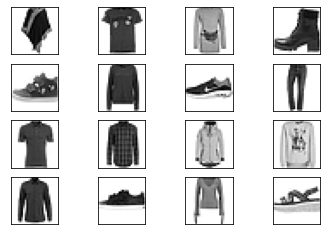

In [6]:
real_samples, mnist_labels = next(iter(train_dataloader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [7]:
"""
Determine if any GPUs are available
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output



In [10]:
discriminator = Discriminator().to(device=device)

In [11]:
generator = Generator().to(device=device)

In [12]:
lr = 0.0001
num_epochs = 10
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [15]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_dataloader):
        
        
        ### Data for training the discriminator
        real_samples         = real_samples.to(device=device)
        real_samples_labels  = torch.ones((batch_size, 1)).to(device=device)     # assign the "real" label to the samples
        
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)  # Sample some noise to feed the generator
        generated_samples    = generator(latent_space_samples)                   # Generate fake images
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)#  assign the "fake" label to the samples
        
        all_samples        = torch.cat((real_samples, generated_samples))        # Concatenate fake and real samples
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels)) # Concatenate fake and real labels

        
        ### Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator   = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        ### Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)  # Sample some noise to feed the generator

        ### Training the generator
        generator.zero_grad()
        generated_samples              = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.7040308713912964
Epoch: 0 Loss G.: 0.43923407793045044
Epoch: 1 Loss D.: 0.47261759638786316
Epoch: 1 Loss G.: 1.106710433959961
Epoch: 2 Loss D.: 0.23534530401229858
Epoch: 2 Loss G.: 2.132507801055908
Epoch: 3 Loss D.: 0.0862853080034256
Epoch: 3 Loss G.: 2.751722812652588
Epoch: 4 Loss D.: 0.16260792315006256
Epoch: 4 Loss G.: 2.379204273223877
Epoch: 5 Loss D.: 0.3428035080432892
Epoch: 5 Loss G.: 2.3168039321899414
Epoch: 6 Loss D.: 0.1144602969288826
Epoch: 6 Loss G.: 2.518099069595337
Epoch: 7 Loss D.: 0.30670440196990967
Epoch: 7 Loss G.: 2.060183525085449
Epoch: 8 Loss D.: 0.35198041796684265
Epoch: 8 Loss G.: 1.6916732788085938
Epoch: 9 Loss D.: 0.42507389187812805
Epoch: 9 Loss G.: 1.854236125946045


In [16]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

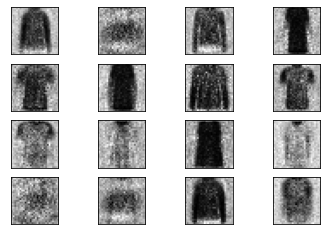

In [17]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])